<a href="https://colab.research.google.com/github/bokutachi256/gisday2019/blob/main/2_%E5%82%BE%E6%96%9C%E9%87%8F%E3%81%A8%E6%9B%B2%E7%8E%87%E3%81%AE%E8%A8%88%E7%AE%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 傾斜量と曲率の計算

* GIS Day in 東京 2019 Eコース
* Pythonを用いたDEM処理
* 首都大学東京 都市環境学部 地理環境学科 中山大地
* 2019年12月21日 首都大学東京 南大沢キャンパス
* 
* [github repository: www.github.com/bokutachi256/gisday2019](https://www.github.com/bokutachi256/gisday2019)

# はじめに

この章ではDEMを用いて傾斜量と曲率を求めます．

傾斜量も曲率も標高の二次元配列から計算しますが，
Pythonはループを使った配列処理が遅いため，
NumPyを用いて高速化します．

# 計算の準備

## ライブラリのインストール


標準ではGoogle Colaboratoryに用意されていないライブラリ（`pysheds`）を，pipをマジックコマンドで使ってインストールします．
マジックコマンドはGoogle Colaboratory上でUNIXのコマンドを実行する方法です．


In [ ]:
#!pip install pysheds

## ライブラリのインポート

このプログラムでは，以下のライブラリを使用します．

* `numpy`: 多次元配列計算のライブラリ．
* `matplotlib.pyplot`: グラフ作成・データ可視化ライブラリ．
* `matplotlib.colors`: カラーライブラリ．
* `pysheds`：流路網・流域処理のライブラリ．GeoTiffの読み書きにも使用．
* `google.colab`: Google Colaboratory用ライブラリ．google driveのマウントに使用．




In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid
from pysheds.view import Raster, ViewFinder
#from google.colab import drive

## Google Driveのマウント



`drive.mount`を使ってGoogle DriveをGoogle Colaboratoryにマウントします．
`drive.mount`の引数はGoogle Colaboratory内のマウントポイントです．
このマウントポイントで示されたディレクトリにGoogle Driveのルートディレクトリ（マイドライブ）が接続されます．

`drive.mount`が実行されると，どのGoogleアカウントで接続するか聞かれます．
適切なアカウントを指定してアクセス権を与えます．
その後認証コードが発行されますので，それをコピーしてテキストボックスにペーストしてください．
これでGoogle Driveがマウントされます．

マイドライブの中に作業用のディレクトリ`gisday2019`を作成してください．
この作業用ディレクトリへのフルパスは`/drive/My Drive/gisday2019`になります．
これを変数`base_dir`に格納しておきます．

In [11]:
#drive.mount('/content/drive')
base_dir = "./5mDEM/"

## DEMの読み込み

`pysheds`の`Grid`オブジェクトを使用して
GeoTiff形式ののDEMを読み込みます．
まずはインスタンス`grid`を作成します．


In [12]:
grid = Grid()


次に`read_raster`メソッドでGeoTiffファイルを読み込みます．
読み込み元のGeoTiffファイルは，作業用フォルダ`base_dir`の中の`GSI-DEM`にある`miyake_dem_JGD2011_zone9.tif`です．
GeoTiff内の標高値は`dem`にします．
これ以降，標高値には`grid.dem`でアクセスできます．


In [13]:
dem = grid.read_raster(base_dir + 'output_dem_reprojected_5m.tif')

DEMの座標系を確認しましょう．
`dem.crs.crs`で取得できます．

In [14]:
dem.crs.crs

<Derived Projected CRS: EPSG:6677>
Name: JGD2011 / Japan Plane Rectangular CS IX
Axis Info [cartesian]:
- [north]: Northing (metre)
- [east]: Easting (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: Japanese Geodetic Datum 2011
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

JGD2011の第IX系であることがわかります．

次に標高値の座標上の範囲（bounding box）を確認します．
これは`bbox`属性から取得できます．

In [15]:
dem.bbox

(-64265.0, -55320.0, -52860.0, -45995.0)

以上，正常にGeoTiffが読み込めたことが確認できました．

# 傾斜量の計算



## 傾斜量の定義

$i \times j$メッシュのDEMを考えます．
ここで，$z$は各メッシュにおける標高です．

$$
   DEM =
    \begin{bmatrix}
      z_{11} & z_{21} & z_{31} & \ldots & z_{i1}\\
      z_{12} & z_{22} & z_{32} & \ldots & z_{i2}\\
      z_{13} & z_{23} & z_{33} & \ldots & z_{i3}\\
      \vdots & \vdots & \vdots & \ddots & \vdots\\
      z_{1j} & z_{2j} & z_{3j} & \ldots & z_{ij}
    \end{bmatrix}
$$


任意の点$(i, j)$における傾斜量$slope_{ij}$は以下のように定義されます．
これは任意の点の東西南北4点の標高値から傾斜を求める方法です．

$$
  Slope_{ij} = \sqrt{G^{2}+H^{2}}
$$

$G$および$H$は以下のように定義できます．

$$
  G = \frac{-z_{(i-1, j)} + z_{(i+1, j)}}{2d}\\
  
  H = \frac{z_{(i, j-1)} - z_{(i, j+1)}}{2d}\\
$$


$d$はメッシュ間隔です．


## 実際の計算

メッシュ間隔$d$はプロパティ`dem.affine`から取得できます．
`dem.affine`の内容を確認してみましょう．




In [16]:
dem.affine

Affine(5.0, 0.0, -64265.0,
       0.0, -5.0, -45995.0)

1番目の要素の5.0が東西方向のメッシュ間隔，
5番目の要素の-5.0が南北方向のメッシュ間隔です．
メッシュ間隔には方向があり，東西方向で正，南北方向で負になります．

$G$と$H$を計算します．
$G$は任意の点の東西方向の両隣の標高値から，
$H$は南北の両隣の標高値から求めます．

DEMは二次元配列になっているため，両隣の要素を取得して
配列全体で$G$と$H$を計算するためには
二重ループを回して計算する必要があります．
しかしpythonでは`for`ループを用いた配列処理が遅いためおすすめできる方法ではありません．
ここでは高速な配列計算ライブラリであるNumPyを利用して，
配列同士の計算で傾斜量を求めていきます．
幸いなことにGeoTiffから読み込んだ標高配列`grid.dem`は
NumPyの配列である`np.ndarray`になっているので，
高速な配列計算が可能です．

## 配列のシフト

任意のメッシュの上下左右の標高値を取得するために，
`grid.mesh`を上下左右にシフトした配列を作ります．
配列のシフトには`np.roll`を使います．
`np.roll`では第一引数にシフトしたい配列，
第二引数にシフト量，第三引数にシフトさせる軸です．
第二引数と第三引数には複数のパラメーターを指定できます．

例えば右メッシュを中央に持ってきたい場合にはx軸に沿って1メッシュ左方向にシフトします．
これは以下のようになります．

```
np.roll(grid.dem, -1, axis = 1)
```
これは配列`grid.dem`を`1`の軸（x軸）の右方向に`-1`，すなわち左に1メッシュシフトします．

複数軸に沿って同時にシフトしたい場合，
例えば左上メッシュを中央に持ってきたい場合には，
x軸に沿って1メッシュ右方向に，y軸に沿って1メッシュ下にシフトさせます．
タプルを使って複数の値を指定します．

```
np.roll(grid.dem, (1, 1), axis = (1, 0))
```
上の例では`1`の軸（x軸）の正方向（右方向）に`1`メッシュ，
`0`の軸（y軸）の正方向（下方向）`1`メッシュシフトすることになります．

これを利用して$z_{11}$から$z_{33}$の配列を作ります．

In [17]:
z11 = np.roll(dem, ( 1, 1), axis = (1, 0)) #左上メッシュを中央にシフト
z31 = np.roll(dem, (-1, 1), axis = (1, 0)) #右上メッシュを中央にシフト
z13 = np.roll(dem, ( 1,-1), axis = (1, 0)) #左下メッシュを中央にシフト
z33 = np.roll(dem, (-1,-1), axis = (1, 0)) #右下メッシュを中央にシフト

z12 = np.roll(dem,  1, axis = 1) #左メッシュを中央にシフト
z32 = np.roll(dem, -1, axis = 1) #右メッシュを中央にシフト

z21 = np.roll(dem,  1, axis = 0) #上メッシュを中央にシフト
z23 = np.roll(dem, -1, axis = 0) #下メッシュを中央にシフト

z22 = dem #z22は真ん中メッシュなのでgrid.demと同じ

## 配列の計算

次に$G$と$H$を求めます．
メッシュサイズは`dem.affine`の最初の要素なので，
`dem.affine[0]`で求まります．メッシュサイズは常に正である必要があるため，`abs`で絶対値を取ります．

$G$と$H$は単純な配列の計算で求まります．

In [18]:
d = np.abs(dem.affine[0])
G = (-z12 + z32) / (2 * d)
H = (z21 - z23) / (2 * d)

$G$と$H$から傾斜量を求めます．
ここも単純な配列の計算です．
$G$と$H$の二乗の平方根`np.sqrt`を使います．

In [19]:
slope = np.sqrt((G * G) + (H * H))

$G$と$H$はともに高さを距離で割った値になりますので，無次元の勾配になります．
アークタンジェント（`np.arctan`）でラジアンに変換し，さらに`np.rad2deg`で度に変換します．

In [20]:
slope_deg = np.rad2deg(np.arctan(slope))

## 傾斜量の図化

以上で傾斜量の計算が終わりました．
`plt.imshow`で図化してみます．

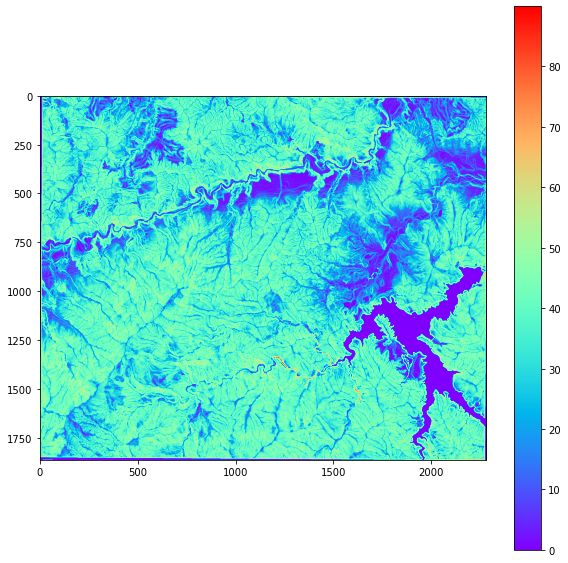

In [21]:
plt.figure(figsize = (10,10))
im = plt.imshow(slope_deg, cmap = "rainbow")
plt.colorbar(im)
plt.show()

`slope_deg`に範囲を指定することで，
一部分のみを図化することもできます．

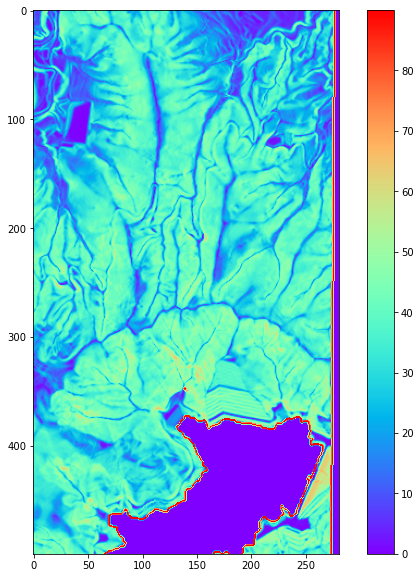

In [22]:
plt.figure(figsize = (10, 10))
im = plt.imshow(slope_deg[500:1000, 2000:2500], cmap = "rainbow")
plt.colorbar(im)
plt.show()

# 曲率の計算

## 曲率の定義

傾斜量とほとんど同じ方法で求められる地形量に曲率があります．
曲率には断面曲率（Profile Curvature; PrC）と
平面曲率(Plan Curvature; PlC）があります．
断面曲率は地形断面の曲率，すなわち凹型斜面・直線斜面・凸型斜面を，
水平曲率は等高線の曲率，すなわち尾根型斜面，谷型斜面を表す地形量です．

これらの曲率の定義は以下になっています．




傾斜量の計算と同様に$m \times n$メッシュのDEMを考えます．
ここで，$z$は各メッシュにおける標高です．

$$
DEM =
  \begin{bmatrix}
    z_{11} & z_{21} & z_{31} & \ldots & z_{m1}\\
    z_{12} & z_{22} & z_{32} & \ldots & z_{m2}\\
    z_{13} & z_{23} & z_{33} & \ldots & z_{m3}\\
    \vdots & \vdots & \vdots & \ddots & \vdots\\
    z_{1n} & z_{2n} & z_{3n} & \ldots & z_{mn}
  \end{bmatrix}
$$

任意の点$(i, j)$における断面曲率$PrC_{ij}$と水平曲率$PlC_{ij}$は以下の式で求まります．

$$
PrC_{ij} = \frac{2(DG^{2}+ EH^{2}+FGH)}{(G^{2}+H^{2})}
PlC_{ij} = \frac{-2(DH^{2}+EG^{2}-FGH)}{(G^{2}+H^{2})}
$$

$D$，$E$，$F$，$G$および$H$は以下の定義になります．

$$
D = \frac{\left(z_{(i-1, j)} + z_{(i+1, j)}\right)/2-z_{(i,j)}}{d^{2}}\\
E = \frac{\left(z_{(i, j-1)} + z_{(i, j+1)}\right)/2-z_{(i,j)}}{d^{2}}\\
F = \frac{-z_{(i-1, j-1)}+z_{(i+1,j-1)}+z_{(i-1,j+1)}-z_{(i+1, j+1)}}{4d^{2}}\\
G = \frac{-z_{(i-1, j)} + z_{(i+1, j)}}{2d}\\
H = \frac{z_{(i, j-1)} - z_{(i, j+1)}}{2d}
$$

$d$はメッシュ間隔です．

## 実際の計算

`D`，`E`，`F`を計算します．

In [23]:
D = (((z12 + z32) / 2) - z22) / (d * d)
E = (((z21 + z23) / 2) - z22) / (d * d)
F = (z31 + z13 - z33 - z11) / (4 * d * d)

`PrC`と`PlC`も計算します．

In [24]:
prc = (2 * ((D * G * G) + (E * H * H) + (F * G * H))) / ((G * G) + (H * H))
plc = ((-2 * ((D * H * H) + (E * G * G) - (F * G *H))) / ((G * G) + (H * H)))

/var/folders/gk/y3j8tnl95hx7bhq7hg5jhgn40000gn/T/ipykernel_14529/2357602341.py:1: RuntimeWarning: invalid value encountered in true_divide
  prc = (2 * ((D * G * G) + (E * H * H) + (F * G * H))) / ((G * G) + (H * H))
/var/folders/gk/y3j8tnl95hx7bhq7hg5jhgn40000gn/T/ipykernel_14529/2357602341.py:2: RuntimeWarning: invalid value encountered in true_divide
  plc = ((-2 * ((D * H * H) + (E * G * G) - (F * G *H))) / ((G * G) + (H * H)))


## 曲率の図化

傾斜量と同様に曲率も図化して確認しましょう．
まずは断面曲率`prc`を図化します．
曲率の範囲は狭いのですが，海面や内水域（貯水池や湖沼など）は標高値が-9999になっているため，
その周辺では値が飽和しています．
このため，`plt.imshow`の`vmin`と`vmax`で表示する値域の最小値と最大値をそれぞれ-0.05と0.05にします．

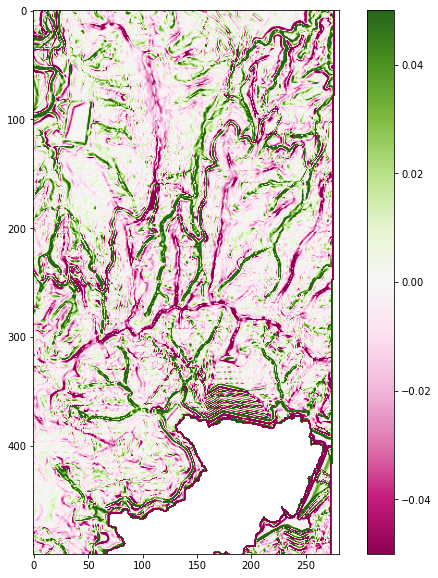

In [25]:
plt.figure(figsize = (10, 10))
im = plt.imshow(prc[500:1000, 2000:2500], cmap = "PiYG", vmin = -0.05, vmax = 0.05)
plt.colorbar(im)
plt.show()

負の断面曲率は凸型斜面，正は凹型斜面，0は直線斜面になります．

水平曲率`plc`も同様に図化します．

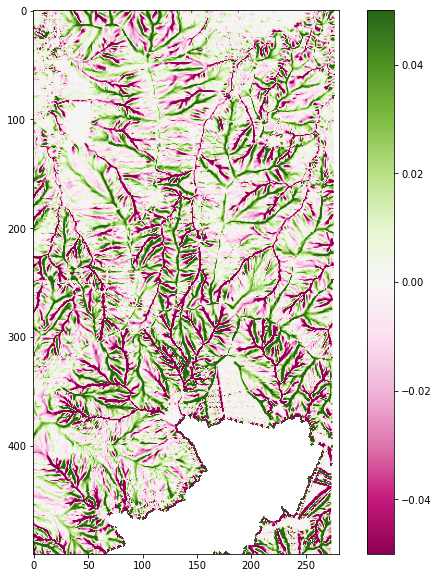

In [26]:
plt.figure(figsize = (10,10))
im = plt.imshow(plc[500:1000, 2000:2500], cmap = "PiYG", vmin = -0.05, vmax = 0.05)
plt.colorbar(im)
plt.show()

負の水平曲率は谷型，正の水平曲率は尾根型，0は直線型の斜面になります．

# 傾斜量と曲率をGeoTiffで保存する

傾斜量と曲率をGeoTiffで保存します．
DEMの読み込みではGRID型のオブジェクト`grid`を作成し，
これにGeoTiffを読み込みました．
計算した傾斜量と曲率は読み込んだGeoTiffの`grid.dem`をもとにして計算しているため，
サイズや参照座標系は`grid.dem`と同じです．
したがって，オブジェクト`grid`に傾斜量と曲率を加えてGeoTiffに出力することが可能です．

`grid`オブジェクトの`add_griddata`メソッドを使って傾斜量をオブジェクト`grid`に追加します．
第一引数は追加したい配列なので`slope`にします．
第二引数は追加した配列の`grid`オブジェクト内での名前です．`slope`としました．
第三引数は北西端の座標やメッシュサイズを格納したアフィンパラメーターです．
`grid.dem`と同じものを使うので`grid.affine`にします．
第四引数は参照座標系です．これも`grid.dem`と同じなので`girid.crs`とします．
第五引数はデータなしを示す値です．ここではとりあえず`-9999`にしておきます．



In [ ]:
#ここは削除予定

#grid.add_gridded_data(data = slope, data_name = 'slope', affine = grid.affine, crs = grid.crs, nodata = -9999)

#dem = Raster(np.where(dem < 0, 0, dem), viewfinder = dem.viewfinder)

次に実際にGeoTiffとして出力します．
出力には`grid`オブジェクトの`to_raster`メソッドを使います．

`to_raster`メソッドの第一引数は書き出すオブジェクト名です．
`grid.slope`を書き出すので`slope`にします．
第二引数は保存するファイル名です．`base_dir`内に`miyake_slope_JGD2011_zone9.tif`として保存します．
第三・第四引数はTiffのブロックサイズです．
ここはどのような値が最適なのかよくわかりませんが，
とりあえず16にしました．
第五引数は保存範囲の指定です．
指定しない場合はデフォルトで`False`になっているはずなのですが，
明示的に指定しないとうまく出力されなかったため，
わざわざ指定しています．
以上で傾斜量をGeoTiffとして保存することができます．

In [27]:
grid.to_raster(slope_deg, base_dir + 'output_dem_slope_deg_reprojected.tif', target_view = slope_deg.viewfinder, blockxsize = 16, blockysize = 16)

曲率もGeoTiffに出力します．

In [28]:
#grid.add_gridded_data(data = PrC, data_name = 'prc', affine = grid.affine, crs = grid.crs, nodata = -9999)
grid.to_raster(prc, base_dir + 'output_dem_prc_reprojected.tif', target_view = prc.viewfinder, blockxsize = 16, blockysize = 16)

#grid.add_gridded_data(data = PlC, data_name = 'plc', affine = grid.affine, crs = grid.crs, nodata = -9999)
grid.to_raster(plc, base_dir + 'output_dem_plc_reprojected.tif', target_view = plc.viewfinder, blockxsize = 16, blockysize = 16)

# 全部入りのプログラム

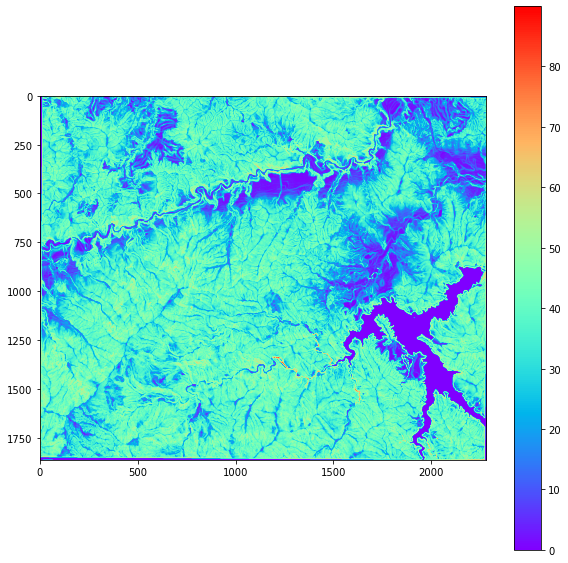

/var/folders/gk/y3j8tnl95hx7bhq7hg5jhgn40000gn/T/ipykernel_14529/612765455.py:51: RuntimeWarning: invalid value encountered in true_divide
  prc = (2 * ((D * G * G) + (E * H * H) + (F * G * H))) / ((G * G) + (H * H))
/var/folders/gk/y3j8tnl95hx7bhq7hg5jhgn40000gn/T/ipykernel_14529/612765455.py:52: RuntimeWarning: invalid value encountered in true_divide
  plc = ((-2 * ((D * H * H) + (E * G * G) - (F * G *H))) / ((G * G) + (H * H)))


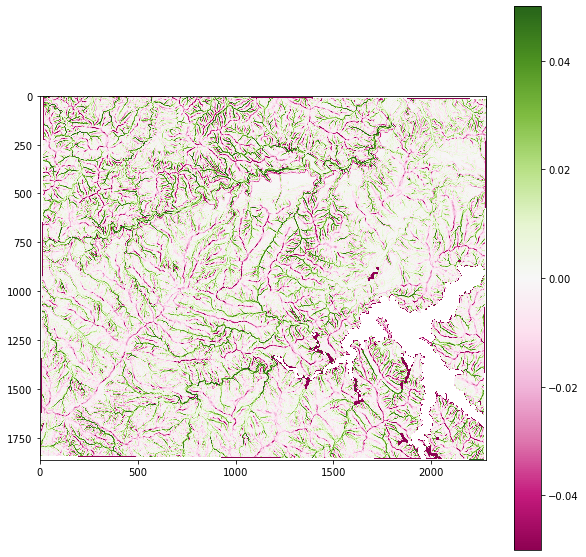

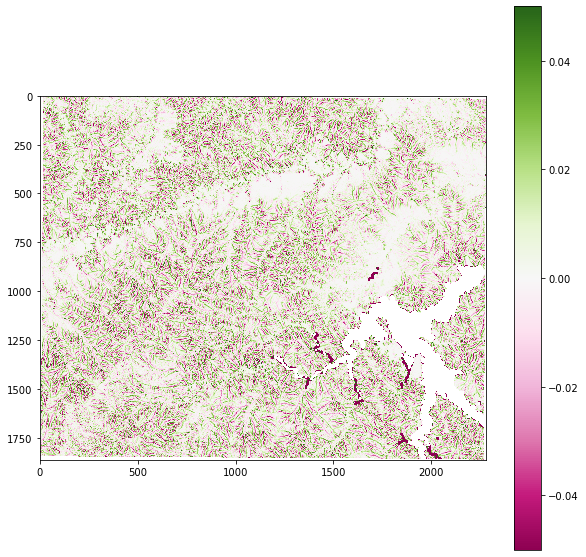

In [32]:
# ライブラリの読み込み
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid
from pysheds.view import Raster, ViewFinder
#from google.colab import drive

# 作業用フォルダの設定
#drive.mount('/content/drive')
base_dir = "./5mDEM/"

# DEMの読み込み
grid = Grid()
dem = grid.read_raster(base_dir + 'output_dem_reprojected_5m.tif')

# DEMのシフト）
z11 = np.roll(dem, ( 1, 1), axis = (1, 0)) #左上メッシュを中央にシフト
z31 = np.roll(dem, (-1, 1), axis = (1, 0)) #右上メッシュを中央にシフト
z13 = np.roll(dem, ( 1,-1), axis = (1, 0)) #左下メッシュを中央にシフト
z33 = np.roll(dem, (-1,-1), axis = (1, 0)) #右下メッシュを中央にシフト

z12 = np.roll(dem,  1, axis = 1) #左メッシュを中央にシフト
z32 = np.roll(dem, -1, axis = 1) #右メッシュを中央にシフト

z21 = np.roll(dem,  1, axis = 0) #上メッシュを中央にシフト
z23 = np.roll(dem, -1, axis = 0) #下メッシュを中央にシフト

z22 = dem #z22は真ん中メッシュなのでgrid.demと同じ

# 傾斜量の計算
d = np.abs(dem.affine[0])
G = (-z12 + z32) / (2 * d)
H = (z21 - z23) / (2 * d)

slope = np.sqrt((G * G) + (H * H))
slope_deg = np.rad2deg(np.arctan(slope))

# 傾斜量の図化
plt.figure(figsize = (10,10))
im = plt.imshow(slope_deg, cmap = "rainbow")
plt.colorbar(im)
plt.show()

# 曲率の計算

D = (((z12 + z32) / 2) - z22) / (d * d)
E = (((z21 + z23) / 2) - z22) / (d * d)
F = (z31 + z13 - z33 - z11) / (4 * d * d)

prc = (2 * ((D * G * G) + (E * H * H) + (F * G * H))) / ((G * G) + (H * H))
plc = ((-2 * ((D * H * H) + (E * G * G) - (F * G *H))) / ((G * G) + (H * H)))

plt.figure(figsize = (10, 10))
im = plt.imshow(prc, cmap = "PiYG", vmin = -0.05, vmax = 0.05)
plt.colorbar(im)
plt.show()

plt.figure(figsize = (10, 10))
im = plt.imshow(plc, cmap = "PiYG", vmin = -0.05, vmax = 0.05)
plt.colorbar(im)
plt.show()

# 傾斜量，断面曲率，水平曲率をGeoTiffで保存する
grid.to_raster(slope_deg, base_dir + 'output_dem_slope_deg_reprojected.tif', target_view = slope_deg.viewfinder, blockxsize = 16, blockysize = 16)
grid.to_raster(prc, base_dir + 'output_dem_prc_reprojected.tif', target_view = prc.viewfinder, blockxsize = 16, blockysize = 16)
grid.to_raster(plc, base_dir + 'output_dem_plc_reprojected.tif', target_view = plc.viewfinder, blockxsize = 16, blockysize = 16)
